## Setup & Load Results

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp

import custom.new_gridsearch as ng

from datetime import datetime

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-17


In [4]:
%%capture

# load grid searches
mod_path = os.path.join("data","3_modeling")
filename = '01112021_rf_gridsearches.joblib'
                
gridsearches = joblib.load(os.path.join(mod_path, filename))

In [ ]:
def extract_df(dic):
    gd_X = dic['representation']
    gd_res = dic['gridsearch_res'].cv_results_
    df = pd.concat([
                    pd.DataFrame({'representation':[gd_X] * len(gd_res["params"])}),
                    pd.DataFrame(gd_res["params"]),
                    pd.DataFrame(gd_res["mean_test_acc"], columns=["mean_val_acc"]),
                    pd.DataFrame(gd_res["mean_test_tpr"], columns=["mean_val_tpr"]),
                    pd.DataFrame(gd_res["mean_test_tnr"], columns=["mean_val_tnr"]),
                    pd.DataFrame(gd_res["mean_fit_time"], columns=["mean_fit_time"])
                   ]
                   , axis=1)
    return df

# create list of dfs
df_list = []
for ix, dic in enumerate(gridsearches):
    df_list.append(extract_df(dic))

# flatten and reindex
dfm = pd.concat(df_list)
dfm.index = range(len(dfm))

In [18]:
# top 6 by mean fit time (descending so, worst offenders)
dfm.sort_values(by=['mean_fit_time'], ascending=False).iloc[:6,:]

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time
13,X_bot_cossim_bot,30,500,5,500,0.986329,0.930567,0.994879,85.328248
5,X_bot_cossim_bot,20,500,5,500,0.986329,0.930567,0.994879,85.167853
7,X_bot_cossim_bot,20,500,10,500,0.986672,0.933131,0.994879,84.324610
29,X_tfidf_cossim_tfidf,30,500,5,500,0.987010,0.933131,0.995266,83.614118
23,X_tfidf_cossim_tfidf,20,500,10,500,0.987352,0.935695,0.995266,83.417150
21,X_tfidf_cossim_tfidf,20,500,5,500,0.987010,0.933131,0.995266,83.219947


In [19]:
# top 6 by sensitivity 
dfm.sort_values(by=['mean_val_tpr'], ascending=False).iloc[:6,:]

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time
16,X_tfidf_cossim_tfidf,20,200,5,200,0.987692,0.938259,0.995266,18.358610
24,X_tfidf_cossim_tfidf,30,200,5,200,0.987692,0.938259,0.995266,21.409068
17,X_tfidf_cossim_tfidf,20,200,5,500,0.987693,0.935695,0.995660,43.773937
30,X_tfidf_cossim_tfidf,30,500,10,200,0.987352,0.935695,0.995266,32.677336
28,X_tfidf_cossim_tfidf,30,500,5,200,0.987352,0.935695,0.995266,34.877201
25,X_tfidf_cossim_tfidf,30,200,5,500,0.987693,0.935695,0.995660,48.788397


In [25]:
# concatenate representation and n_estimators for plt.xlabel
dfm['xticks'] = dfm.agg(lambda x: f"{x['representation']}-{x['max_depth']}-\
{x['max_features']}-{x['min_samples_split']}-{x['n_estimators']}", axis=1)

In [73]:
from sklearn.preprocessing import minmax_scale

dfm['mean_fit_time_scaled'] = minmax_scale(dfm['mean_fit_time'], feature_range=(0.92, .99), axis=0, copy=True)

In [74]:
import matplotlib.pyplot as plt

def plot_topscores(X):
    X = X.sort_values(by=['mean_val_tpr'], ascending=False)
    plt.figure(figsize=(16, 8))
    plt.plot(np.array(X['mean_val_acc']), label="mean validation accuracy")
    plt.plot(np.array(X['mean_val_tpr']), label="mean validation sensitivity", color='red')
    plt.plot(np.array(X['mean_val_tnr']), label="mean validation specificiy")
    plt.plot(np.array(X['mean_fit_time_scaled']), label="mean fit time, scaled", ls='--', lw=1, color='black')
    plt.title('Evaluating Representations - Sorted By Mean Validation Sensitivity', fontsize=14)
    plt.xticks(np.arange(len(X)), tuple(X['xticks']))
    plt.legend(loc="lower left", fontsize=12)
    plt.axis([0, len(X), 0.9, 1.01])
    plt.xticks(rotation=90)
    plt.show()

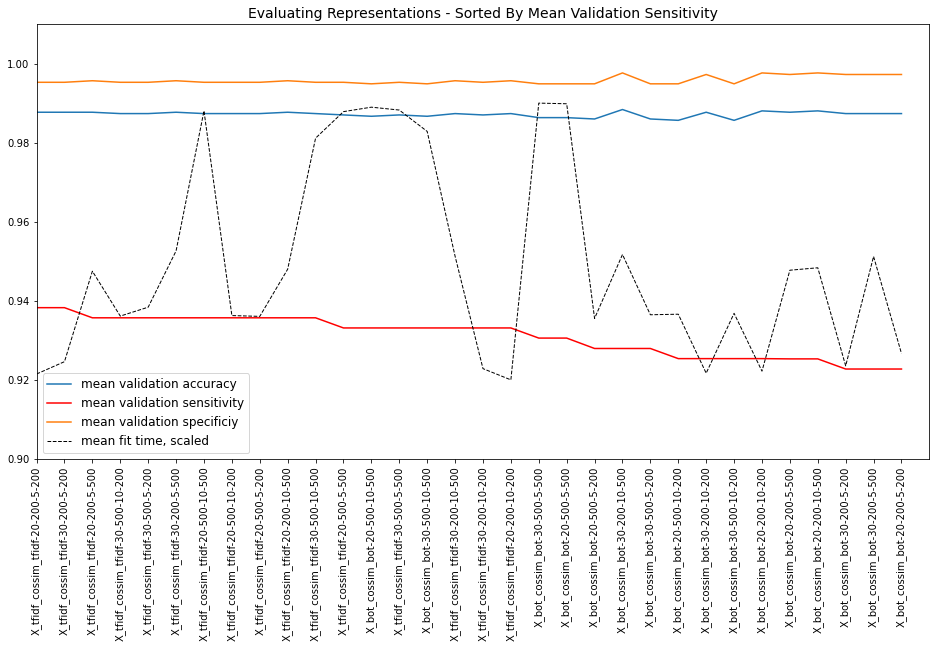

In [75]:
plot_topscores(dfm)

Fortunately, the top model is actually quite fast, so we can just go with that.

## Picking a Decision Threshold

Rerunning entire pipeline for this one model.

Save IDF, etc., reproducible for TEST SET!

In [76]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

y = y_train.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

In [77]:
import custom.clean_preprocess as cp
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))])

X_tfidf = pipe.fit_transform(X_train)

In [78]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

def perform_SVD(X, n_components=300): # vary this next?
    
    X_array = X.asfptype()
    U, Sigma, VT = svds(X_array.T, # term-document matrix
                        k=n_components)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    
    # return V 
    V = VT.T
    return V # no need to scale for random forests

X_svd_tfidf = perform_SVD(X_tfidf)

In [80]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

X_cossim_svd_tfidf = cosine_similarity(X_svd_tfidf)

train_df = pd.DataFrame({'sms':X_train, 'target':y_train})

# get spam indexes
spam_ix = train_df.loc[train_df['target']=='spam'].index

# calculate average spam similarity on SVD
mean_spam_sims_tfidf = []

for ix in range(X_cossim_svd_tfidf.shape[0]):
    mean_spam_sims_tfidf.append(np.mean(X_cossim_svd_tfidf[ix, spam_ix]))

X_tfidf_cossim_tfidf = sp.hstack((csr_matrix(mean_spam_sims_tfidf).T, X_svd_tfidf))  # noticed mistake, rerunning nbks 13,14